In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import geopandas as gpd
from shapely.geometry import Point
import shapely
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.tsa.stattools as sm

/Users/VarshiniSelvadurai/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/VarshiniSelvadurai/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/VarshiniSelvadurai/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/VarshiniSelvadurai/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
data = pd.read_excel('/Users/VarshiniSelvadurai/Documents/Internship/Crime_Edited.xlsx', sheet_name = 'March')
#data = pd.read_excel('C:\\Users\\vns8\\Documents\\Crime_Edited.xlsx', sheet_name = 'March')
data = data.loc[data["Crime Name1"] != "Not a Crime"]
data = data.drop(columns = ["Police District Number","Address Number","Victims","CR Number","NIBRS Code","Beat","PRA","State","Incident ID","Offence Code","Sector","Police District Name","Crime Name2","Crime Name3","Agency","Place","End Date/Time","Dispatch Date/Time","Block_Address"])
ugh = list(map(str, data["Start Time"]))
for i in range (0, len(ugh)):
    ugh[i] = ugh[i][:2]
data["Start Time"] = ugh
ugh = (list(map(str,data['Start Date'])))
ughh = []
for i in range(0,len(ugh)):
    ugh[i] = ugh[i][5:]
    ugh[i] = ugh[i][:5]
data['Start Date'] = ugh

In [3]:
z_20902 = data.loc[data["Zip Code"] == 20902]
z_20906 = data.loc[data["Zip Code"] == 20906]
z_20904 = data.loc[data["Zip Code"] == 20904]
z_20910 = data.loc[data["Zip Code"] == 20910]
z_20874 = data.loc[data["Zip Code"] == 20874]

# CASE 1

In [3]:
def case1(data, title):
    start_date = list(map(str, data['Start Date'].value_counts().keys().tolist()))
    start_date.sort()
    start_time = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    start_time.sort()
    ugh = [0 for i in range(0,len(start_date)*len(start_time))]
    ughh = [0 for i in range(0,len(start_date)*len(start_time))]
    for index,row in data.iterrows():
        a = start_date.index(row["Start Date"])
        b = int(row["Start Time"])
        ugh[24*a + b] += 1
        ughh[24*a + b] = row["Start Date"] + row["Start Time"]
    march = pd.DataFrame({"Crime Count": ugh, "Date and Time":ughh})
    ax = march.plot(kind = "line", y = "Crime Count", figsize = (20,5), title = ("March 12-25" +str(title)), xticks = [i for i in range (0,336,24)], grid = True,legend = False)
    ax.set_xlabel("Hour (14 days)")
    ax.set_ylabel("Crime Frequency")
    fig = ax.get_figure()
    fig.savefig("March 12-15"+str(title)+".png")
    return march

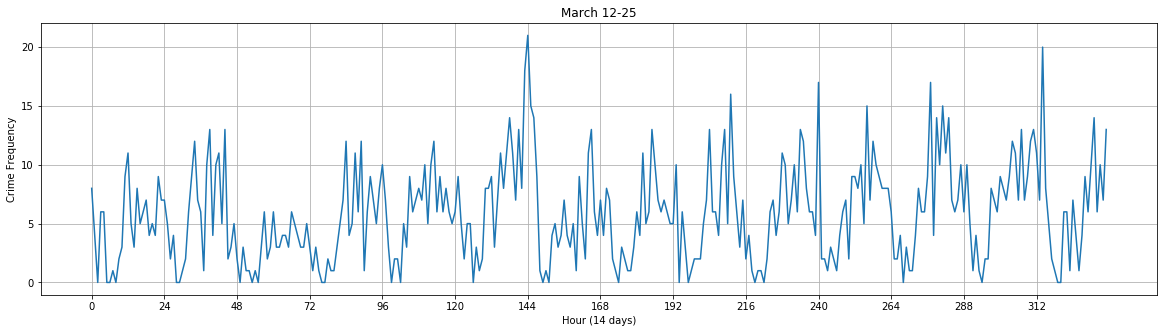

In [4]:
hour_data = case1(data,"")

### ARIMA

##### Not super sure what the results mean...

                             ARIMA Model Results                              
Dep. Variable:          D.Crime Count   No. Observations:                  335
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -914.250
Method:                       css-mle   S.D. of innovations              3.706
Date:                Fri, 27 Jul 2018   AIC                           1834.499
Time:                        10:00:13   BIC                           1845.942
Sample:                             1   HQIC                          1839.061
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0131      0.141      0.093      0.926      -0.264       0.290
ar.L1.D.Crime Count    -0.4326      0.049     -8.757      0.000      -0.529      -0.336
                

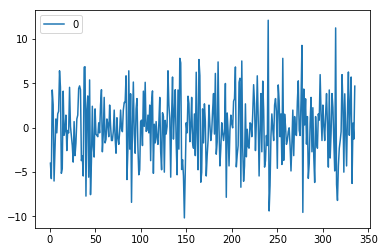

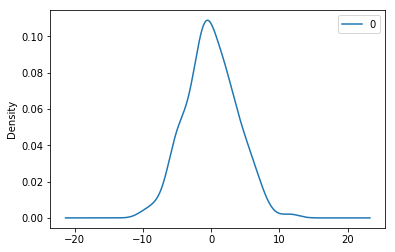

                0
count  335.000000
mean    -0.005182
std      3.712395
min    -10.181736
25%     -2.316575
50%     -0.288511
75%      2.548586
max     12.116006


In [6]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(hour_data["Crime Count"], order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

### Power Spectrum - Periodogram

##### IT WORKS: at least im assuming it does cause the period is 24 hours... 

Max Frequency: 0.041666666666666664 Hz
Period = 1/ Frequency: 24.0 hours


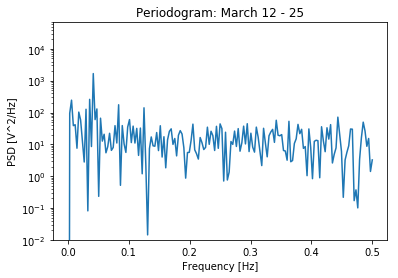

In [5]:
from scipy import signal
f, Pxx_den = signal.periodogram(hour_data["Crime Count"])
fig, ax = plt.subplots()  # create figure & 1 axis  
ax.semilogy(f, Pxx_den)
plt.title("Periodogram: March 12 - 25")
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.ylim(10**-2)
fig.savefig("periodogram - march.png")
max_frequency = (f[list(Pxx_den).index(max(Pxx_den))])
print("Max Frequency:", max_frequency, "Hz")
print("Period = 1/ Frequency: " + str(1/max_frequency) + " hours")

In [27]:
print(f[2])
print((1/f[2]))

0.005952380952380952
168.0


### Seasonal Decomposition

##### additive vs. multiplicative: neither works

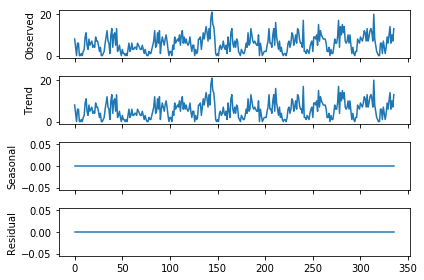

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(hour_data["Crime Count"], model='additive', freq=1)
result.plot()
plt.show()

result = seasonal_decompose(hour_data["Crime Count"], model='multiplicative', freq=1)
result.plot()
plt.show()

### Autocorrelation Plot

##### shows that the best lag against itself is 1 (obvious) --> not sure how it relates to seasonality

/Users/VarshiniSelvadurai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


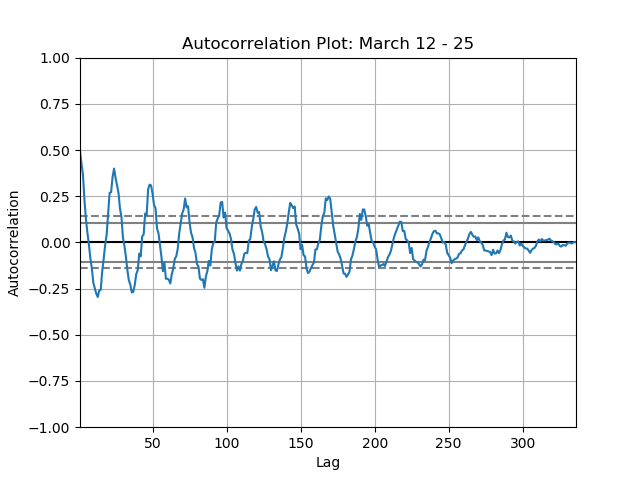

In [6]:
%matplotlib notebook
#LOOK AT DISTANCE BETWEEN PEAKS
from pandas.tools.plotting import autocorrelation_plot
ax = autocorrelation_plot(hour_data["Crime Count"])
ax.set_title("Autocorrelation Plot: March 12 - 25")
fig = ax.get_figure()
fig.savefig("autocorrelation plot.png")
#shows that optimal lag is 0

### Seasonal Subseries Plot

##### Can show an overall trend (usefull to see increase in weekends) but not sure how to do this in python (i don't think there is a function for this)

### Boxplot

##### If you look at the medians in the boxplot you can see a general trend...this works the same and the seasonal subseries but figuring out how to do that might be more effective

{'whiskers': [<matplotlib.lines.Line2D at 0x1c1d3b72e8>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1cbef438>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c1d3b7d68>,
 'medians': [<matplotlib.lines.Line2D at 0x1c1d38ab38>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c1d38ae48>,
 'means': []}

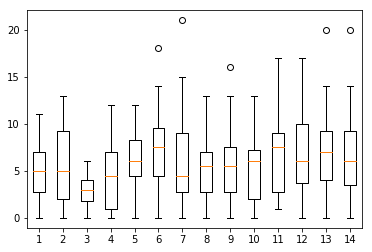

In [10]:
fig, ax = plt.subplots()
h = [list(hour_data["Crime Count"])[0:24],
    list(hour_data["Crime Count"])[24:48],
    list(hour_data["Crime Count"])[48:72],
    list(hour_data["Crime Count"])[72:96],
    list(hour_data["Crime Count"])[96:120],
    list(hour_data["Crime Count"])[120:144],
    list(hour_data["Crime Count"])[144:168],
    list(hour_data["Crime Count"])[168:192],
    list(hour_data["Crime Count"])[192:216],
    list(hour_data["Crime Count"])[216:240],
    list(hour_data["Crime Count"])[240:264],
    list(hour_data["Crime Count"])[264:288],
    list(hour_data["Crime Count"])[288:2312],
    list(hour_data["Crime Count"])[312:336]]
ax.boxplot(h)

# CASE 2 

##### Still confused about the 4 different tests...but p values are all > .3

In [33]:
def case2(data, title):
    start_date = list(map(str, data['Start Date'].value_counts().keys().tolist()))
    start_date.sort()
    ugh = [0 for i in range(0,len(start_date))]
    ughh = [0 for i in range(0,len(start_date))]
    for index,row in data.iterrows():
        a = start_date.index(row["Start Date"])
        ugh[a] += 1
    march = pd.DataFrame({"Crime Count": ugh, "Date":start_date} )
    march.plot(kind = "line", y = "Crime Count", figsize = (20,10), title = ("March 12-25" +str(title)), xticks = [i for i in range (0,14)], grid = True)
    return march

<IPython.core.display.Javascript object>


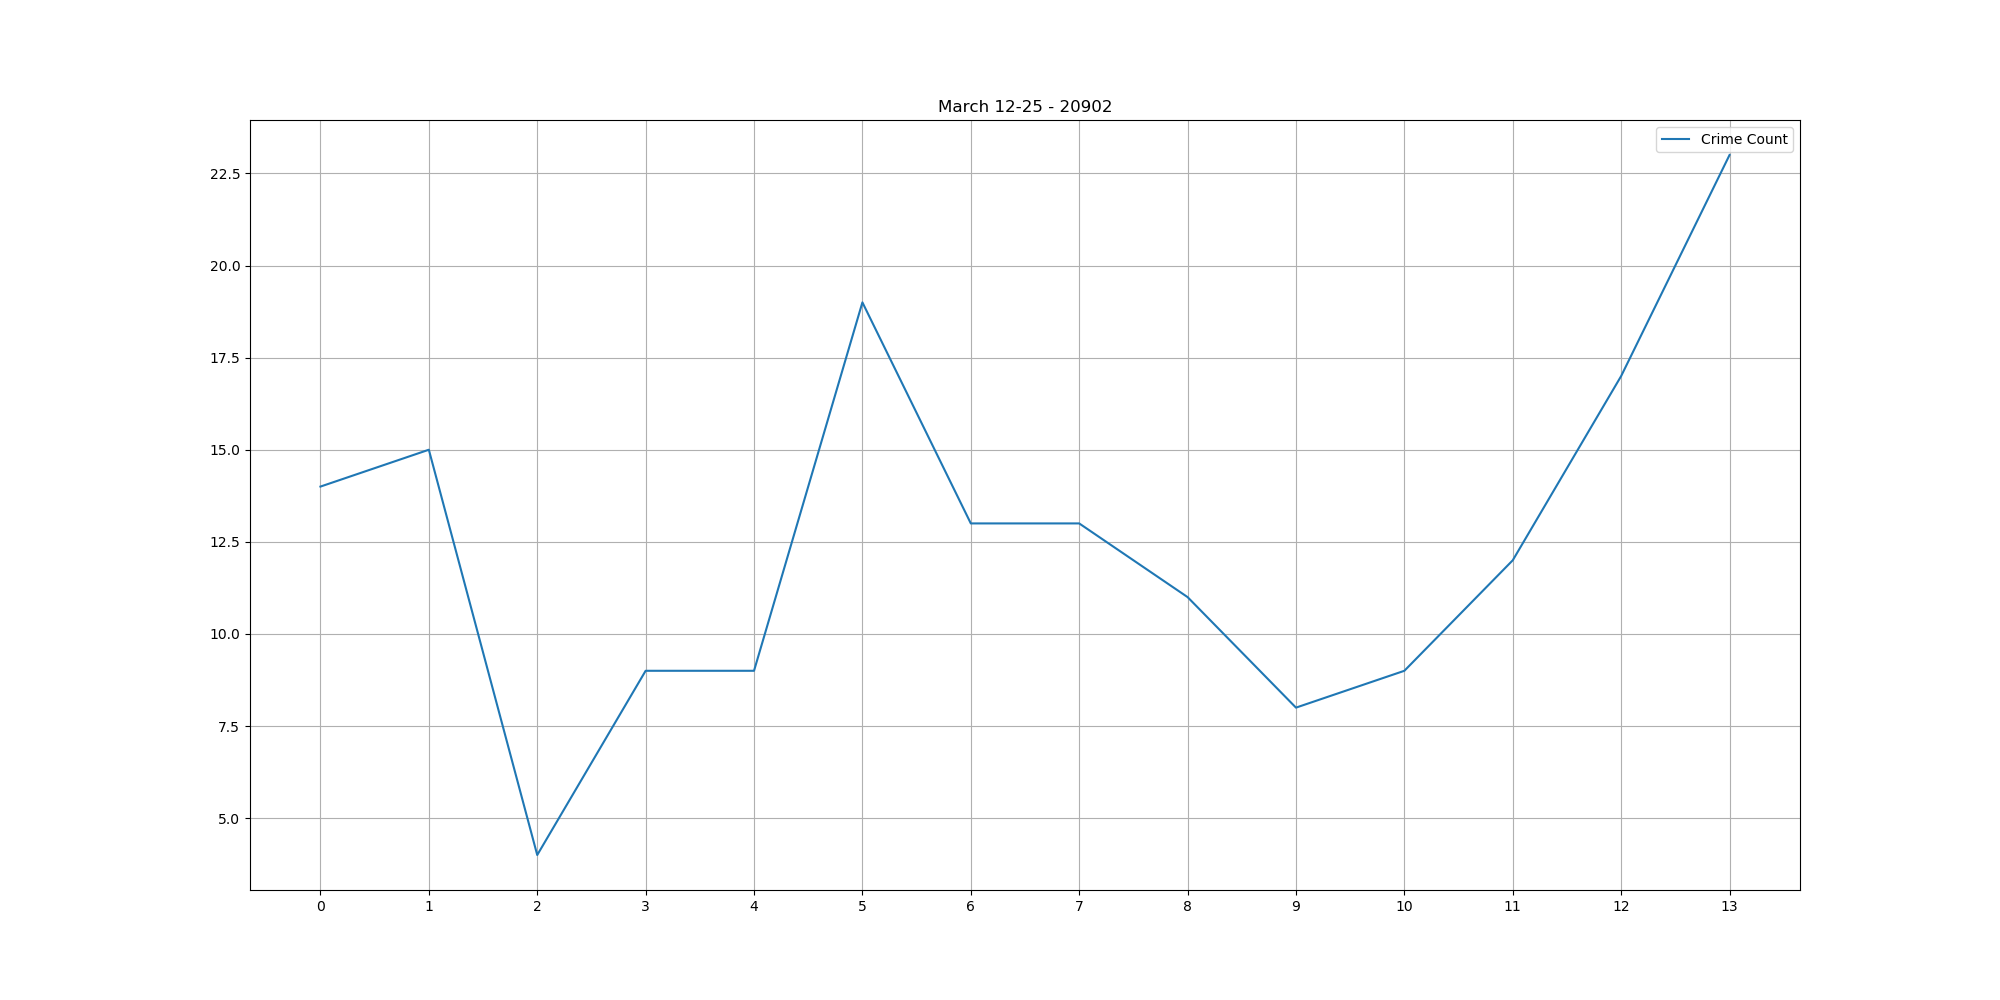

<IPython.core.display.Javascript object>


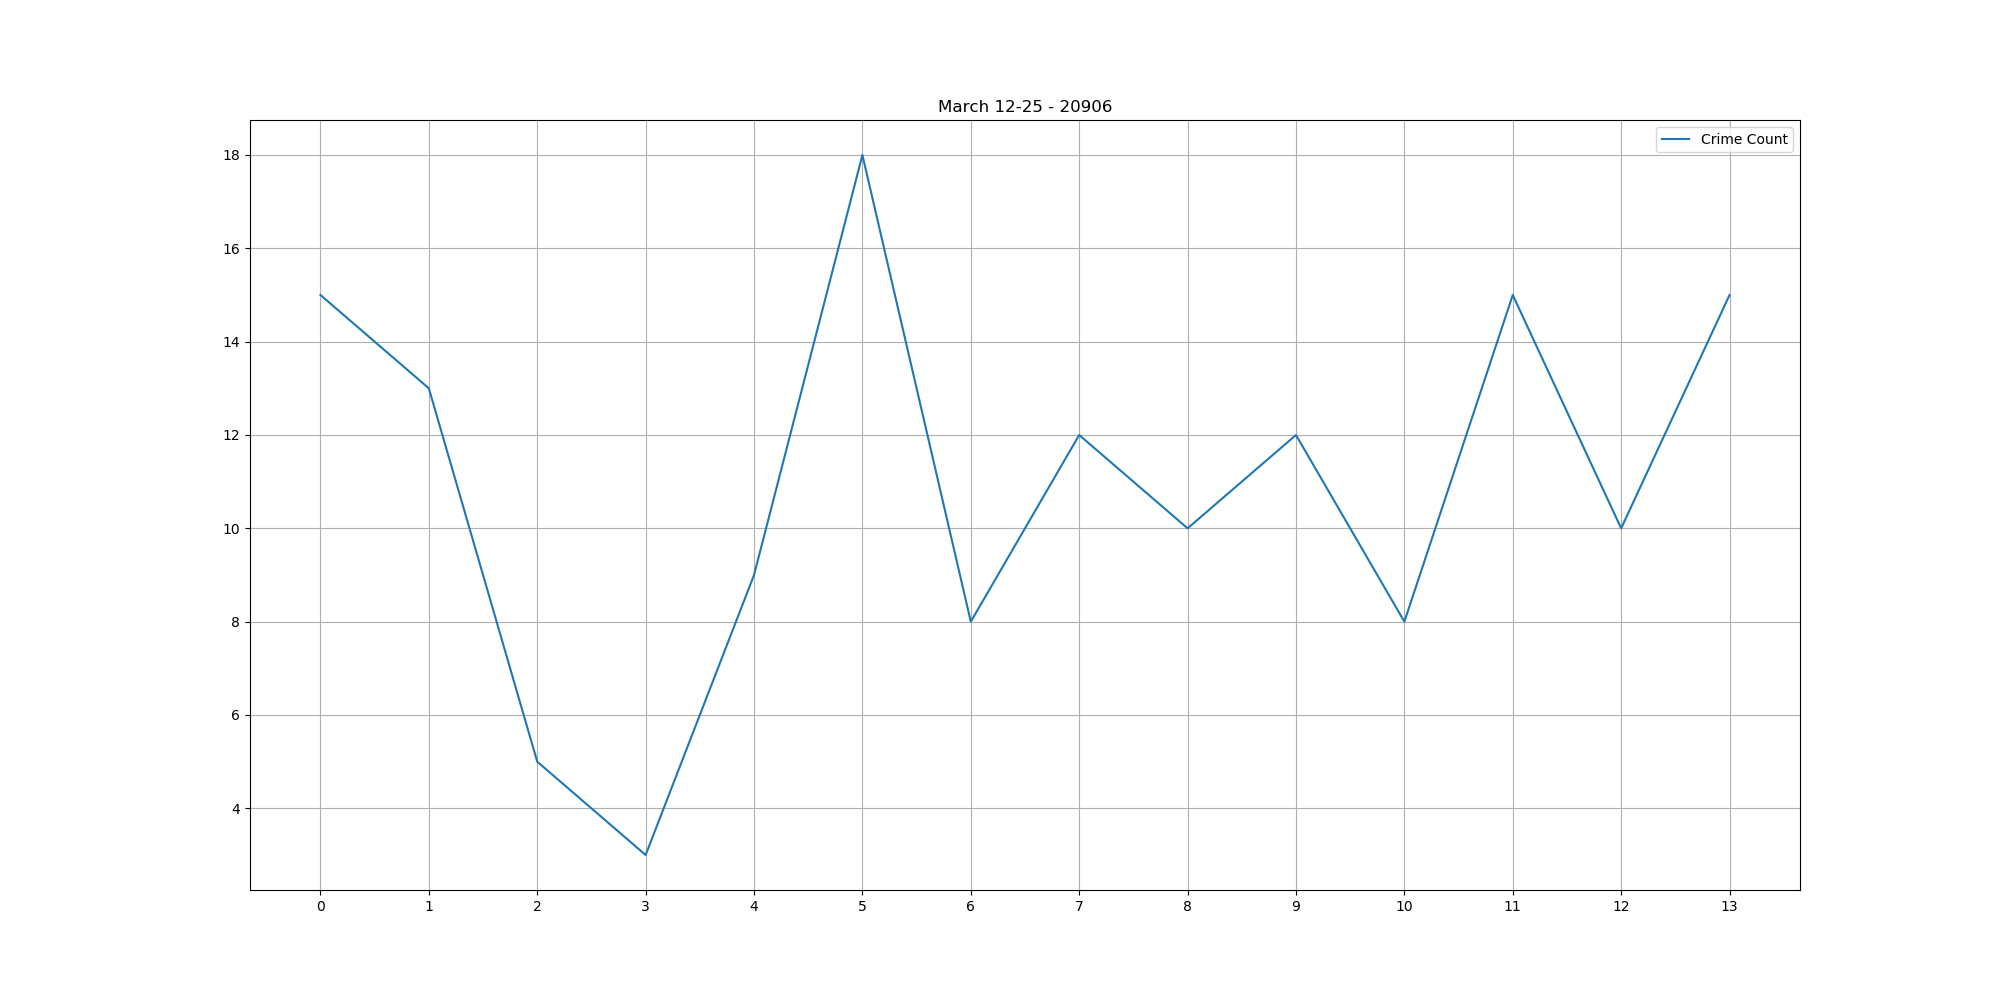

<IPython.core.display.Javascript object>


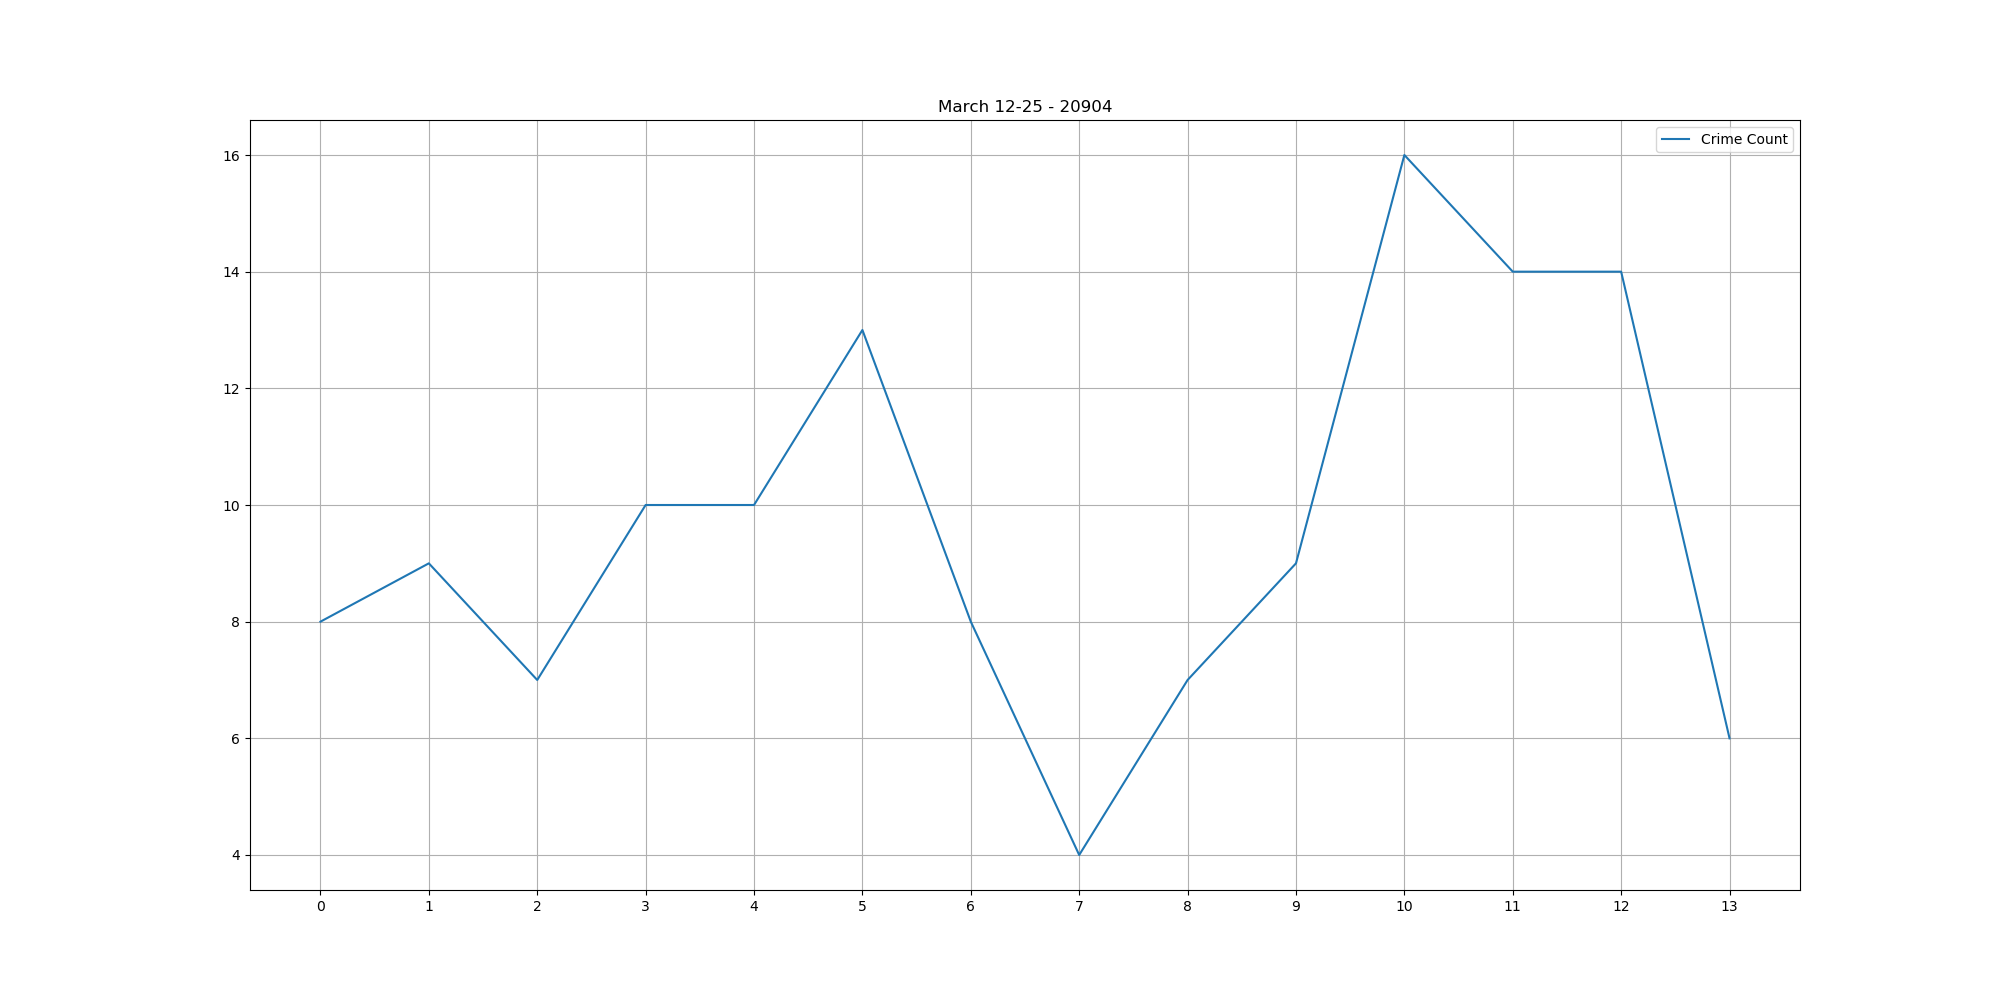

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
day_20902 = case2(z_20902, " - 20902")
day_20906 = case2(z_20906, " - 20906")
day_20904 = case2(z_20904, " - 20904")
day_20910 = case2(z_20910, " - 20910")
day_20874 = case2(z_20874, " - 20874")

In [41]:
zipcodes = [day_20902,day_20904,day_20906,day_20910,day_20874]
names = ["20902","20904","20906","20910","20874"]
i = 0
j = 0
for z in zipcodes:
    for z2 in zipcodes:
        if i!=j:
            x = np.column_stack((list(z["Crime Count"]),list(z2["Crime Count"])))
            print(names[i])
            print(names[j])
            sm.grangercausalitytests(x = x,maxlag = 4)
            print()
        j += 1
    j = 0
    i += 1

20902
20904

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2251  , p=0.1666  , df_denom=10, df_num=1
ssr based chi2 test:   chi2=2.8926  , p=0.0890  , df=1
likelihood ratio test: chi2=2.6118  , p=0.1061  , df=1
parameter F test:         F=2.2251  , p=0.1666  , df_denom=10, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0905  , p=0.0666  , df_denom=7, df_num=2
ssr based chi2 test:   chi2=14.0245 , p=0.0009  , df=2
likelihood ratio test: chi2=9.2896  , p=0.0096  , df=2
parameter F test:         F=4.0905  , p=0.0666  , df_denom=7, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8487  , p=0.1129  , df_denom=4, df_num=3
ssr based chi2 test:   chi2=31.7515 , p=0.0000  , df=3
likelihood ratio test: chi2=14.9326 , p=0.0019  , df=3
parameter F test:         F=3.8487  , p=0.1129  , df_denom=4, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9503  , p=0.6370

likelihood ratio test: chi2=14.2492 , p=0.0065  , df=4
parameter F test:         F=0.7894  , p=0.6767  , df_denom=1, df_num=4

20904
20874

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0012  , p=0.9733  , df_denom=10, df_num=1
ssr based chi2 test:   chi2=0.0015  , p=0.9688  , df=1
likelihood ratio test: chi2=0.0015  , p=0.9688  , df=1
parameter F test:         F=0.0012  , p=0.9733  , df_denom=10, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5984  , p=0.5755  , df_denom=7, df_num=2
ssr based chi2 test:   chi2=2.0518  , p=0.3585  , df=2
likelihood ratio test: chi2=1.8941  , p=0.3879  , df=2
parameter F test:         F=0.5984  , p=0.5755  , df_denom=7, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0365  , p=0.4667  , df_denom=4, df_num=3
ssr based chi2 test:   chi2=8.5507  , p=0.0359  , df=3
likelihood ratio test: chi2=6.3263  , p=0.0968  , df=3
parameter F test:         F=1.0365  

ssr based F test:         F=0.1152  , p=0.9579  , df_denom=1, df_num=4
ssr based chi2 test:   chi2=4.6072  , p=0.3300  , df=4
likelihood ratio test: chi2=3.7893  , p=0.4353  , df=4
parameter F test:         F=0.1152  , p=0.9579  , df_denom=1, df_num=4

20874
20910

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2608  , p=0.6207  , df_denom=10, df_num=1
ssr based chi2 test:   chi2=0.3390  , p=0.5604  , df=1
likelihood ratio test: chi2=0.3347  , p=0.5629  , df=1
parameter F test:         F=0.2608  , p=0.6207  , df_denom=10, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2383  , p=0.7941  , df_denom=7, df_num=2
ssr based chi2 test:   chi2=0.8170  , p=0.6646  , df=2
likelihood ratio test: chi2=0.7904  , p=0.6735  , df=2
parameter F test:         F=0.2383  , p=0.7941  , df_denom=7, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0092  , p=0.4758  , df_denom=4, df_num=3
ssr based chi2 test:

# CASE 3

In [57]:
days = ["Sun","Mon","Tue","Wed","Thu","Fri","Sat","Sun","Mon","Tue","Wed","Thu","Fri","Sat"]
day_20902["Day"] = days
day_20904["Day"] = days
day_20906["Day"] = days
day_20910["Day"] = days
day_20874["Day"] = days

In [59]:
def case3(data, title):
    weekend = pd.DataFrame(columns=["Crime Count","Date","Day"])
    weekday = pd.DataFrame(columns=["Crime Count","Date","Day"])
    i = 0
    j = 0
    for index,row in data.iterrows():
        if row["Day"] == "Sat" or row["Day"] == "Sun":
            weekend.loc[i] = row
            i +=1
        else:
            weekday.loc[j] = row
            j += 1
    case1(data, title)

  Crime Count   Date  Day
0          15  03-13  Mon
1           4  03-14  Tue
2           9  03-15  Wed
3           9  03-16  Thu
4          19  03-17  Fri
5          11  03-20  Mon
6           8  03-21  Tue
7           9  03-22  Wed
8          12  03-23  Thu
9          17  03-24  Fri


In [8]:
from __future__ import print_function

In [11]:
print_function ('x')
print_function  ('y')

TypeError: '_Feature' object is not callable

In [3]:
data = pd.read_excel('/Users/VarshiniSelvadurai/Documents/Internship/Crime_Edited.xlsx', sheet_name = 'Crime_LatLon')
#data = pd.read_excel('C:\\Users\\vns8\\Documents\\Crime_Edited.xlsx', sheet_name = 'March')
data = data.loc[data["Crime Name1"] != "Not a Crime"]
data = data.drop(columns = ["Police District Number","Address Number","Victims","CR Number","NIBRS Code","Beat","PRA","State","Incident ID","Offence Code","Sector","Police District Name","Crime Name2","Crime Name3","Agency","Place","End Date/Time","Dispatch Date/Time","Block_Address"])
ugh = list(map(str, data["Start Time"]))
for i in range (0, len(ugh)):
    ugh[i] = ugh[i][:2]
data["Start Time"] = ugh
ugh = (list(map(str,data['Start Date'])))
ughh = []
for i in range(0,len(ugh)):
    ugh[i] = ugh[i][5:]
    ugh[i] = ugh[i][:5]
data['Start Date'] = ugh


In [8]:
def case1(data, title):
    start_date = list(map(str, data['Start Date'].value_counts().keys().tolist()))
    start_date.sort()
    start_time = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    start_time.sort()
    ugh = [0 for i in range(0,len(start_date)*len(start_time))]
    ughh = [0 for i in range(0,len(start_date)*len(start_time))]
    try:
        for index,row in data.iterrows():
            a = start_date.index(row["Start Date"])
            b = int(row["Start Time"])
            ugh[24*a + b] += 1
            ughh[24*a + b] = row["Start Date"] + row["Start Time"]
    except:
        print()
    march = pd.DataFrame({"Crime Count": ugh, "Date and Time":ughh})
    ax = march.plot(kind = "line", y = "Crime Count", figsize = (20,5), title = ("March 12-25" +str(title)), xticks = [i for i in range (0,336,24)], grid = True,legend = False)
    ax.set_xlabel("Hour (14 days)")
    ax.set_ylabel("Crime Frequency")
    #fig = ax.get_figure()
    #fig.savefig("March 12-15"+str(title)+".png")
    return march

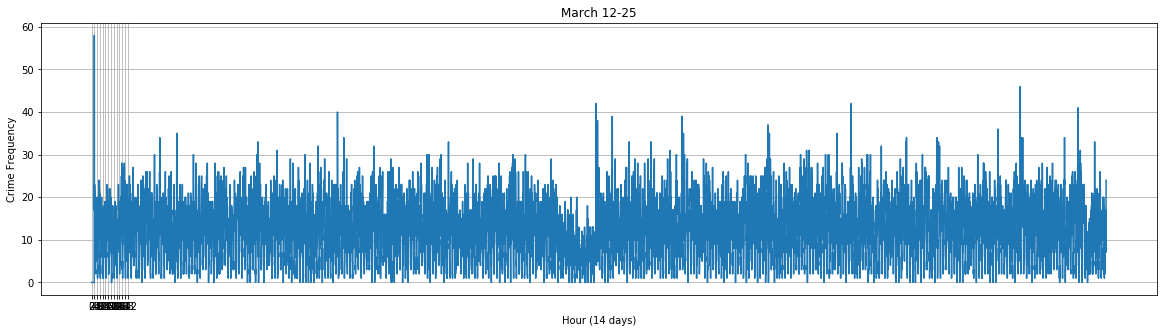

In [9]:
hour_data = case1(data,"")

Max Frequency: 0.041666666666666664 Hz
Period = 1/ Frequency: 24.0 hours


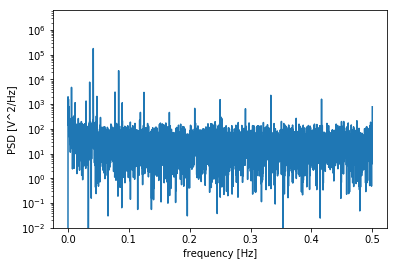

In [10]:
from scipy import signal
f, Pxx_den = signal.periodogram(hour_data["Crime Count"])
fig, ax = plt.subplots()  # create figure & 1 axis  
ax.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.ylim(10**-2)
#fig.savefig("periodogram - march.png")
max_frequency = (f[list(Pxx_den).index(max(Pxx_den))])
print("Max Frequency:", max_frequency, "Hz")
print("Period = 1/ Frequency: " + str(1/max_frequency) + " hours")

/Users/VarshiniSelvadurai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


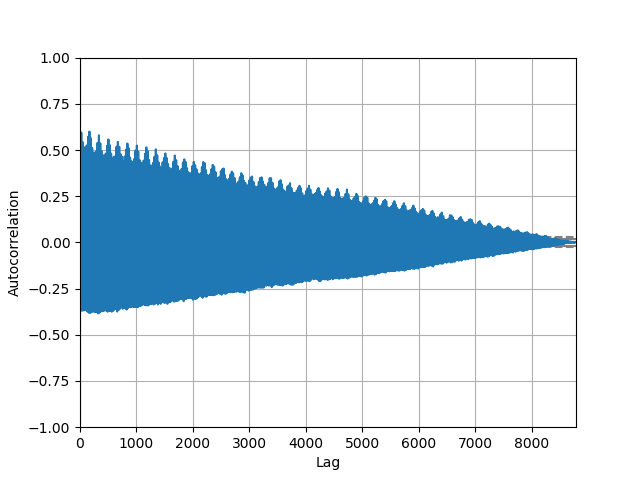

In [11]:
%matplotlib notebook
#LOOK AT DISTANCE BETWEEN PEAKS
from pandas.tools.plotting import autocorrelation_plot
ax = autocorrelation_plot(hour_data["Crime Count"])
#fig = ax.get_figure()
#fig.savefig("autocorrelation plot.png")
#shows that optimal lag is 0